In [99]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import xarray as xr
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import cartopy as cart

from glob import glob
from datetime import timedelta as delta
from datetime import datetime

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)

from importlib import reload
import sys
sys.path.append('/home/students/4302001/arctic-connectivity/tools')
import plot
import lifeline

In [100]:
reload(plot)
reload(lifeline)

<module 'lifeline' from '/home/students/4302001/arctic-connectivity/tools/lifeline.py'>

In [33]:
# Specify paths to velocity field and mesh
#readdir_ocean = '/Users/daanreijnders/Datasets/'
#readdir_ice = '/Users/daanreijnders/Datasets/'

readdir_ice = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ice/arctic/'
readdir_ocean = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ocean/arctic/'
readdir_mesh = '/scratch/DaanR/fields/'

fieldfile_ocean = 'daily_CESM_0.1degree_controlrun_year_300_arctic_region_timed.nc'
fieldfile_ice = 'monthly_icefields_CESM_0.1degree_controlrun_year_300_arctic.nc'
meshfile = 'POP_grid_coordinates.nc'

writedir = ''

In [35]:
# NOT NECESSARY YET
def read_velocity_field(fieldfiles, meshfiles=None):
    if not meshfiles:
        meshfiles = fieldfiles
    filenames = {'U': {'lon': meshfiles,
                       'lat': meshfiles,
                       'data':fieldfiles},
                 'V': {'lon': meshfiles,
                       'lat': meshfiles,
                       'data':fieldfiles}}

    variables = {'U': 'UVEL_5m',
                 'V': 'VVEL_5m'}

    dimensions = {'U': {'time': 'time',
                        'lat': 'ULAT',
                        'lon': 'ULON'},
                  'V': {'time': 'time',
                        'lat': 'ULAT',
                        'lon': 'ULON'}}
    fieldset = FieldSet.from_pop(filenames, variables, dimensions, allow_time_extrapolation=False)
    fieldset.U.vmax = 10;  fieldset.U.vmin = -10;  # set max of flow to 10 m/s
    fieldset.V.vmax = 10; fieldset.V.vmin = -10;
    return fieldset

fieldset = read_velocity_field(readdir_ocean+fieldfile_ocean, readdir_mesh+meshfile)  

In [37]:
meshdata = xr.open_dataset(readdir_mesh+meshfile)

In [7]:
icedata = xr.open_dataset(readdir_ice+fieldfile_ice)

In [12]:
aice

<xarray.DataArray 'aice' (time: 12, nj: 600, ni: 3600)>
[25920000 values with dtype=float32]
Coordinates:
    TLAT     (nj, ni) float32 ...
    TLON     (nj, ni) float32 ...
    ULAT     (nj, ni) float32 ...
    ULON     (nj, ni) float32 ...
  * time     (time) object 0300-02-01 00:00:00 ... 0301-01-01 00:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          %
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    comment:        none
    cell_methods:   time: mean
    time_rep:       averaged

In [80]:
aice = icedata['aice'] #ice area
hisnap = icedata['hisnap'] # ice volume (check if area*thickness)
hi = icedata['hi'] #thickness
tlat_icefile = icedata['TLAT'].data
tlon_icefile = icedata['TLON'].data
tlat_mesh = meshdata['TLAT'].data
tlon_mesh = meshdata['TLON'].data

In [86]:
tlon_icefile[np.isnan(tlon_icefile)] = -1000
tlat_icefile[np.isnan(tlat_icefile)] = -1000

In [87]:
tlat_diff = np.where(tlat_icefile==-1000, 0, tlat_icefile-tlat_mesh)
print('max tlat_diff = ',np.max(tlat_diff))
print('min tlat_diff = ',np.min(tlat_diff))

max tlat_diff =  7.6293945e-06
min tlat_diff =  -67.706215


In [88]:
tlon_diff = np.where(tlon_icefile==-1000, 0, tlon_icefile-tlon_mesh)
print('max tlon_diff = ',np.max(tlon_diff))
print('min tlon_diff = ',np.min(tlon_diff))

max tlon_diff =  1.5258789e-05
min tlon_diff =  -267.24664


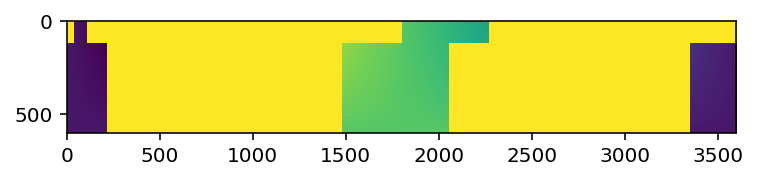

In [89]:
plt.imshow(tlon_diff)

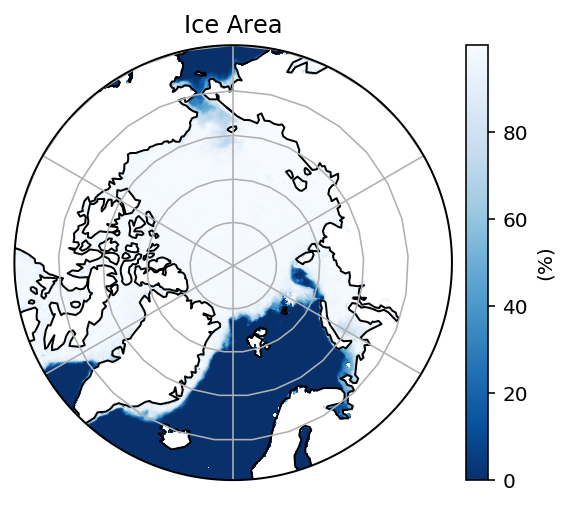

In [97]:
plot.from_dataset(tlon_mesh, tlat_mesh, aice[0,:,:], polar=True, latRange=(60, 90), title='Ice Area', units='%', colormap='Blues_r')

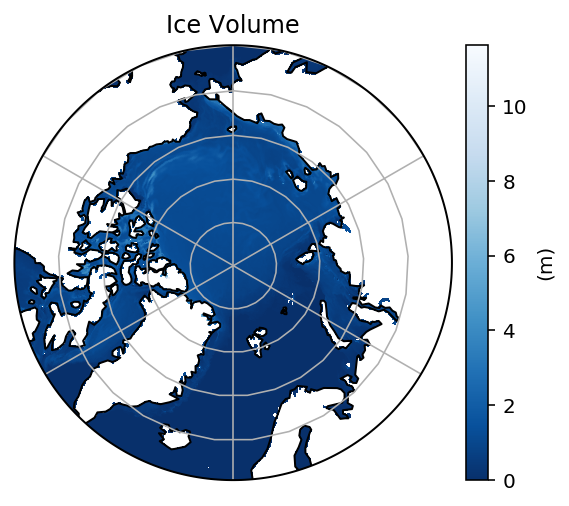

In [101]:
plot.from_dataset(tlon_mesh, tlat_mesh, hisnap[0,:,:], polar=True, latRange=(60, 90), title='Ice Volume', units='m', colormap='Blues_r')

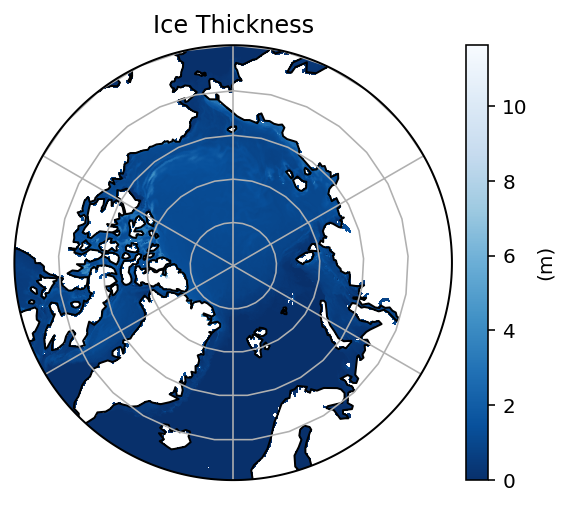

In [102]:
plot.from_dataset(tlon_mesh, tlat_mesh, hisnap[0,:,:], polar=True, latRange=(60, 90), title='Ice Thickness', units='m', colormap='Blues_r')